# Importação das bibliotecas

In [198]:
%run ../services/imports.py
%run ../services/visualization.py
import services.lista_estados_regioes as lesr

%run ../services/function.py
%run ../services/classifier_evaluation.py

In [199]:
# Criar instância da classe
visualizacao = Visualizacao()

In [200]:
dataset_poscomp = pd.read_csv("../dados/homologacao_poscomp/dataset_poscomp.csv")

In [4]:
dataset_poscomp.head()

,NOME,CPF,DATA NASC.,SEXO,ESTADO,INSCRICAO,ESPECIALIDADE,PRESENTE DIA1,CARGO,Matemática Discreta,...,Arquitetura e Organização de Computadores,Redes de Computadores,Computação Gráfica,Inteligência Artificial,Engenharia de Software,Sistemas Distribuídos,Compiladores,Processamento de Imagens,Banco de Dados,ANO
0,ABEL CASTRO CONDORI,000.000.972-32,27/10/1992,M,OU,39401673171-6,Inteligência Artificial,S,Mestrado/Doutorado,3.0,...,1.0,1.0,0.0,2.0,0.0,3.0,0.0,2.0,2.0,2016
1,ABEL CASTRO CONDORI,000.000.972-32,27/10/1992,M,OU,39401673171-6,Linhas de Produto de Software,S,Mestrado/Doutorado,3.0,...,1.0,1.0,0.0,2.0,0.0,3.0,0.0,2.0,2.0,2016
2,ABEL CASTRO CONDORI,000.000.972-32,27/10/1992,M,OU,39401673171-6,"Computação Gráfica, Processamento de Imagens, ...",S,Mestrado/Doutorado,3.0,...,1.0,1.0,0.0,2.0,0.0,3.0,0.0,2.0,2.0,2016
3,ABEL CASTRO CONDORI,000.000.972-32,27/10/1992,M,OU,39401673171-6,Inteligência Computacional,S,Mestrado/Doutorado,3.0,...,1.0,1.0,0.0,2.0,0.0,3.0,0.0,2.0,2.0,2016
4,ABEL CASTRO CONDORI,000.000.972-32,27/10/1992,M,OU,39401673171-6,Inteligência Artificial,S,Mestrado/Doutorado,3.0,...,1.0,1.0,0.0,2.0,0.0,3.0,0.0,2.0,2.0,2016


In [5]:
# deixar os nomes das colunas minúscula
dataset_poscomp.columns = [coluna.lower() for coluna in dataset_poscomp.columns]

In [6]:
# converter os type das colunas
dataset_poscomp["ano"] = dataset_poscomp["ano"].astype("object")

In [7]:
# Primeiramente, será excluídos candidatos que realizaram o exame no Peru
dataset_poscomp = dataset_poscomp.query("estado != 'OU'")

In [8]:
dataset_poscomp.drop([65274, 72776], inplace=True, axis=0)

## Estatisticas sobre candidatos dos sexo diferentes

In [9]:
qtd_registered = dataset_poscomp.drop_duplicates(
    subset="inscricao", keep="first", ignore_index=True
)

In [10]:
qtd_sexo = qtd_registered.groupby(["sexo", "ano"]).size().reset_index(name="counts")
qtd_sexo["sexo"] = qtd_sexo["sexo"].replace({"F": "Feminino", "M": "Masculino"})

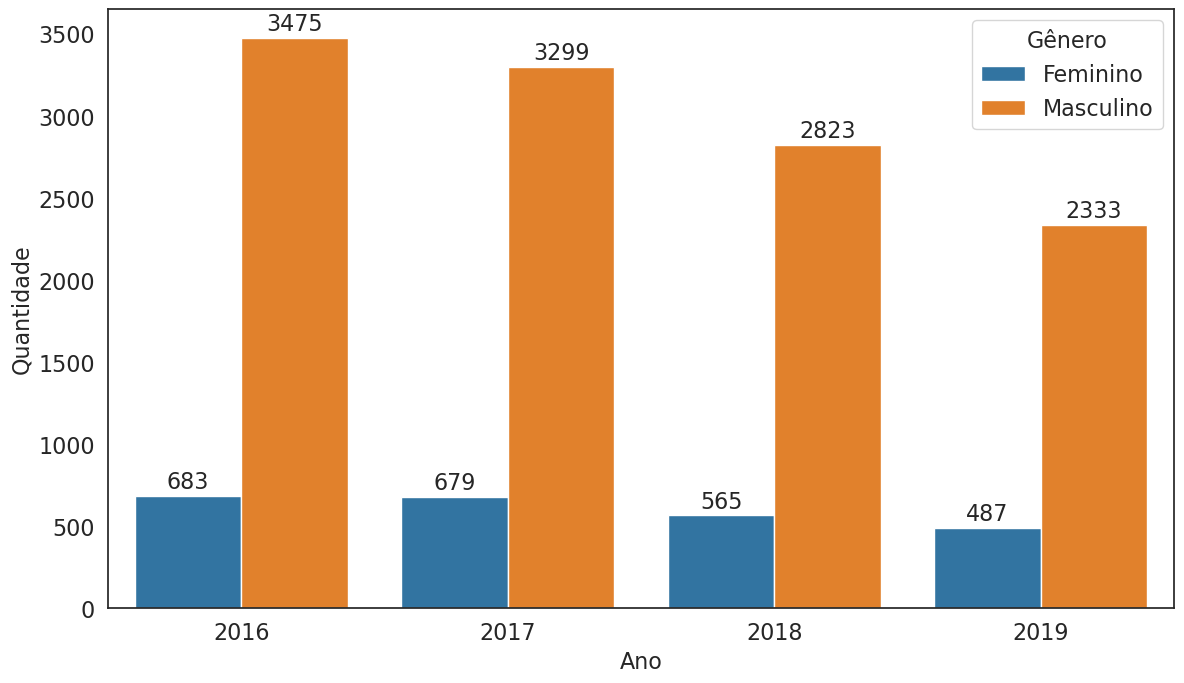

In [11]:
visualizacao.barplot_view(
    qtd_sexo,
    x="ano",
    y="counts",
    hue="sexo",
    fontsize=16,
    xlabel="Ano",
    ylabel="Quantidade",
    figsize=(12, 7),
    title_legend="Gênero",
    save_path="../imagens/qtd_candidatosAno.png",
)

In [12]:
qtd_sexo

,sexo,ano,counts
0,Feminino,2016,683
1,Feminino,2017,679
2,Feminino,2018,565
3,Feminino,2019,487
4,Masculino,2016,3475
5,Masculino,2017,3299
6,Masculino,2018,2823
7,Masculino,2019,2333


In [13]:
qtd_ano = (
    qtd_registered.groupby(["presente dia1", "ano"]).size().reset_index(name="counts")
)

In [14]:
qtd_ano['presente dia1'].replace({'N':'Ausentes',
                                  'S':'Presentes'}, inplace=True)

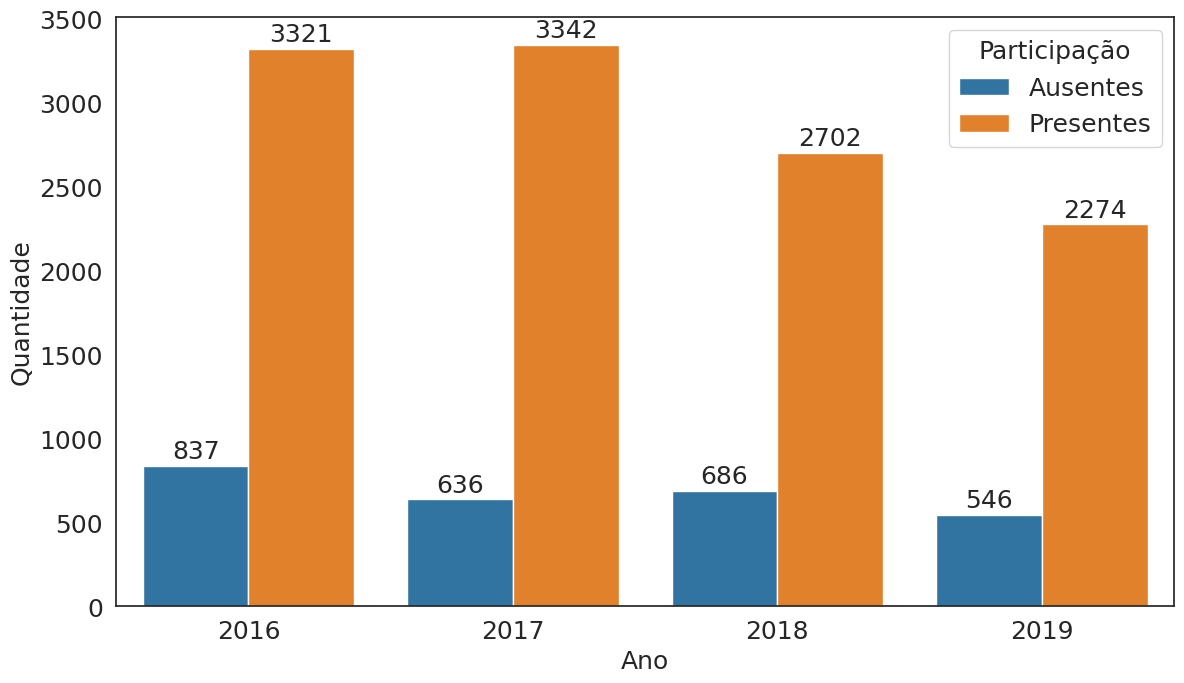

In [15]:
visualizacao.barplot_view(
    dataframe=qtd_ano,
    x="ano",
    y="counts",
    hue="presente dia1",
    title_legend="Participação",
    figsize=(12, 7),
    xlabel='Ano',
    ylabel='Quantidade',
    fontsize=18,
    save_path="../imagens/faltantes_presentes.pdf",
)

## Converter as idade dos candidatos

In [16]:
from datetime import date


def calculate_age(row):
    birth_year = int(
        row["data nasc."].split("/")[-1]
    )  # Extrai o ano de nascimento a partir da data de nascimento
    exam_year = row["ano"]  # Obtém o ano da realização da prova
    age = exam_year - birth_year
    return age


# Aplique a função calculate_age ao DataFrame para calcular as idades com base nos anos.
dataset_poscomp["idade"] = dataset_poscomp.apply(calculate_age, axis=1)

In [17]:
dataset_poscomp = dataset_poscomp.drop(columns=["data nasc."])

In [18]:
dataset_poscomp["idade"].min()

-1

In [19]:
dataset_poscomp = dataset_poscomp[dataset_poscomp["idade"] >= 18]

In [20]:
dataset_poscomp["idade"].value_counts(bins=7, sort=False)

(17.95, 25.0]    43525
(25.0, 32.0]     22433
(32.0, 39.0]      8331
(39.0, 46.0]      2497
(46.0, 53.0]       795
(53.0, 60.0]       163
(60.0, 67.0]        20
Name: count, dtype: int64

In [21]:
dataset_poscomp.duplicated().sum()

4527

## Verificar valos faltantes

In [22]:
colunas_categoricas = [
    "nome",
    "cpf",
    "sexo",
    "estado",
    "especialidade",
    "presente dia1",
    "cargo",
]

for coluna in colunas_categoricas:
    tem_interrigacao = dataset_poscomp[coluna].isna().any()
    if tem_interrigacao:
        print(f"Na coluna ' {coluna} existem valores 'NaN'")

Na coluna ' especialidade existem valores 'NaN'


In [23]:
for coluna in colunas_categoricas:
    dataset_poscomp[coluna] = dataset_poscomp[coluna].replace(" ?", np.nan)

## Ánalises de pessoas inscritas no POSCOMP no decorrer dos anos

In [24]:
# Aqui estou adicionando as regioes dos estados brasileiros
for i in lesr.regioes_brasil_siglas:
    dataset_poscomp.loc[
        dataset_poscomp["estado"].isin(lesr.regioes_brasil_siglas[i]), "regiao"
    ] = i

In [25]:
qtd_registered_year = dataset_poscomp.drop_duplicates(
    subset="cpf", keep="first", ignore_index=True
)

In [26]:
qtd_region = qtd_registered_year.groupby(["regiao"]).size().reset_index(name="counts")

In [27]:
region_percent = qtd_region["counts"].to_numpy()
region_percent = 100 * region_percent / region_percent.sum()
region_percent = np.around(region_percent, 2)

In [28]:
qtd_region["Porcentagem regiao"] = region_percent
# qtd_region.style.format({'Porcentagem regiao':'{:.2f}%'})

In [29]:
region_brazil = {
    "centro_oeste": "Centro Oeste",
    "nordeste": "Nordeste",
    "norte": "Norte",
    "sudeste": "Sudeste",
    "sul": "Sul",
}

In [30]:
qtd_region["regiao"] = qtd_region["regiao"].replace(region_brazil)

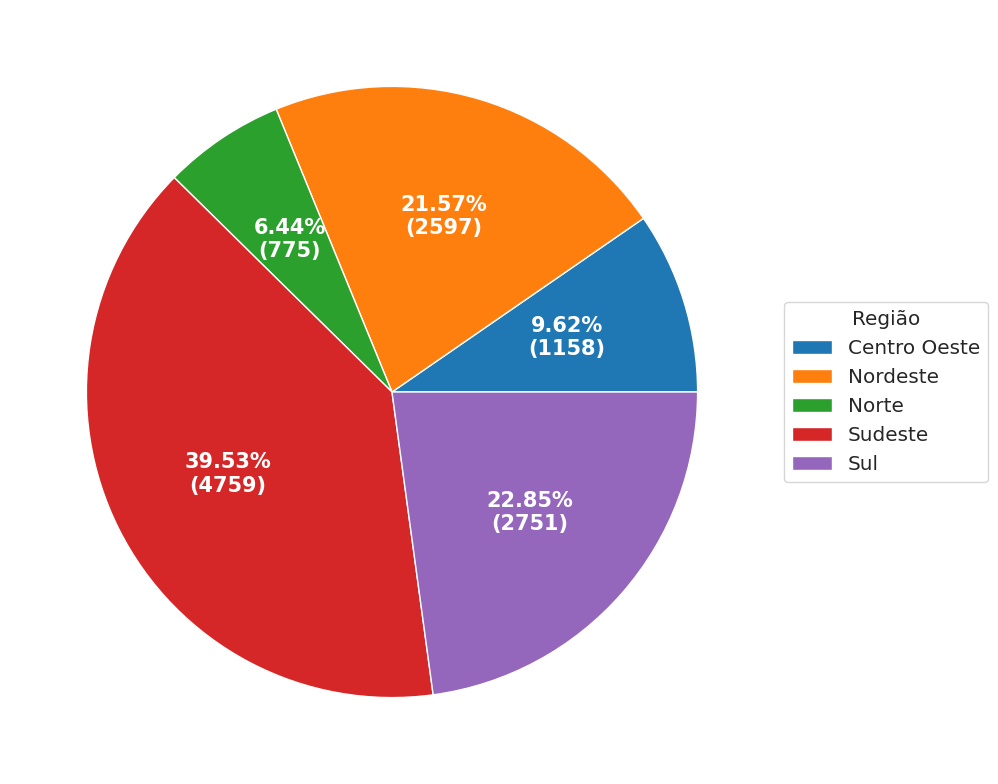

In [31]:
def func(pct, allvals):
    absolute = int(np.round(pct / 100.0 * np.sum(allvals)))
    return f"{pct:.2f}%\n({absolute:d})"


fig, ax = plt.subplots(figsize=(15, 8), subplot_kw=dict(aspect="equal"))

# Usar as informações do DataFrame
wedges, texts, autotexts = ax.pie(
    qtd_region["counts"],
    autopct=lambda pct: func(pct, qtd_region["counts"]),
    textprops=dict(color="w"),
)

ax.legend(
    wedges,
    qtd_region["regiao"],
    title="Região",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1),
    fontsize="large",
    title_fontsize="large",
)

plt.setp(autotexts, size=15, weight="bold")
plt.tight_layout()
plt.savefig("../imagens/pie.pdf", bbox_inches="tight", dpi=600, transparent=True)
plt.show()

In [32]:
qtd_regiao_estado = (
    qtd_registered_year.groupby(["regiao", "estado"]).size().reset_index(name="counts")
)
qtd_regiao_estado["regiao"] = qtd_regiao_estado["regiao"].replace(region_brazil)

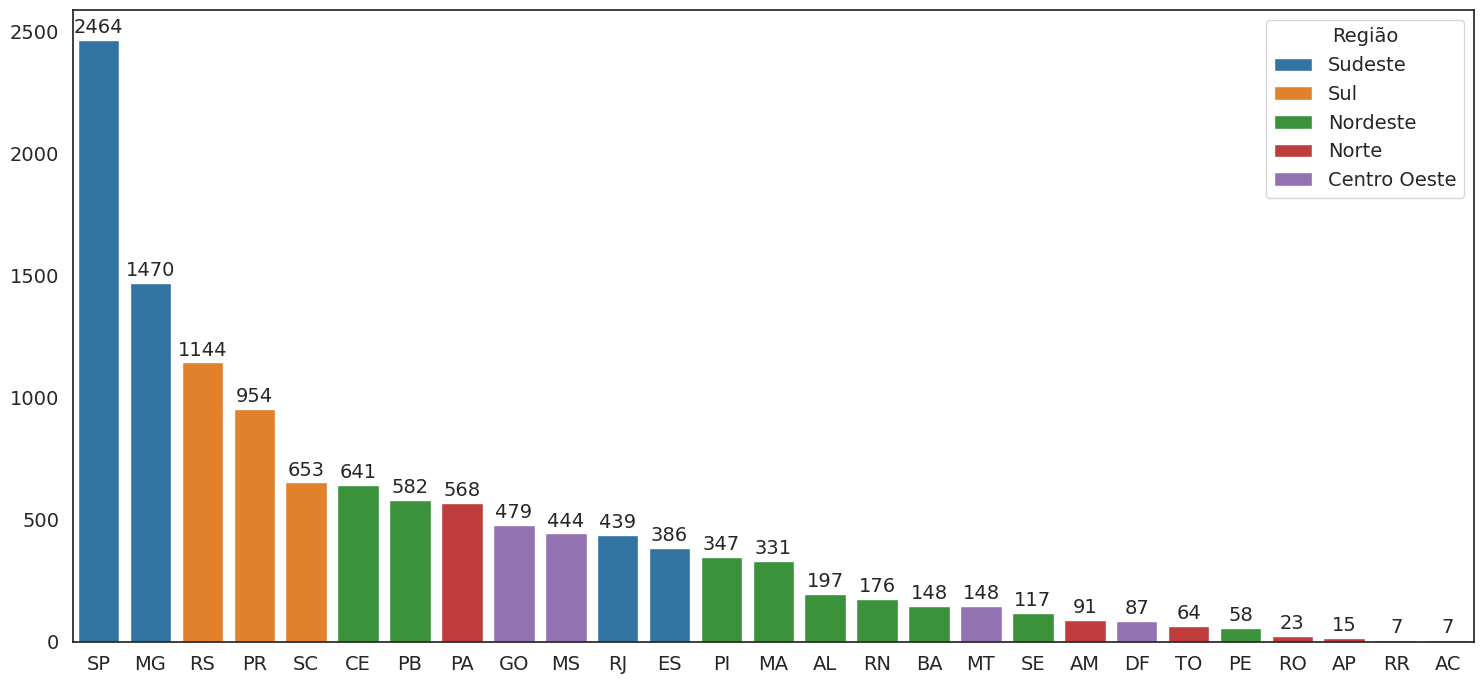

In [33]:
visualizacao.barplot_view(
    qtd_regiao_estado.sort_values(["counts"], ascending=False),
    x="estado",
    y="counts",
    hue="regiao",
    figsize=(15, 7),
    dodge=False,
    title_legend="Região",
    save_path="../imagens/qtd_região.pdf",
)

In [34]:
qtd_region_gender = (
    qtd_registered_year.groupby(["regiao", "sexo"]).size().reset_index(name="counts")
)

In [35]:
qtd_region_gender["regiao"] = qtd_region_gender["regiao"].replace(region_brazil)
qtd_region_gender["sexo"] = qtd_region_gender["sexo"].replace(
    {"F": "Feminino", "M": "Masculino"}
)

In [36]:
qtd_region_gender

,regiao,sexo,counts
0,Centro Oeste,Feminino,177
1,Centro Oeste,Masculino,981
2,Nordeste,Feminino,418
3,Nordeste,Masculino,2179
4,Norte,Feminino,156
5,Norte,Masculino,619
6,Sudeste,Feminino,816
7,Sudeste,Masculino,3943
8,Sul,Feminino,413
9,Sul,Masculino,2338


In [37]:
region_gender_percent = qtd_region_gender["counts"].to_numpy()
region_gender_percent = 100 * region_gender_percent / region_gender_percent.sum()
region_gender_percent = np.around(region_gender_percent, 2)

In [38]:
qtd_region_gender["Porcentagem regiao"] = region_gender_percent
qtd_region_gender.style.format({"Porcentagem regiao": "{:.2f}%"})

,regiao,sexo,counts,Porcentagem regiao
0,Centro Oeste,Feminino,177,1.47%
1,Centro Oeste,Masculino,981,8.15%
2,Nordeste,Feminino,418,3.47%
3,Nordeste,Masculino,2179,18.10%
4,Norte,Feminino,156,1.30%
5,Norte,Masculino,619,5.14%
6,Sudeste,Feminino,816,6.78%
7,Sudeste,Masculino,3943,32.75%
8,Sul,Feminino,413,3.43%
9,Sul,Masculino,2338,19.42%


In [39]:
qtd_region_gender.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   regiao              10 non-null     object 
 1   sexo                10 non-null     object 
 2   counts              10 non-null     int64  
 3   Porcentagem regiao  10 non-null     float64
dtypes: float64(1), int64(1), object(2)
memory usage: 452.0+ bytes


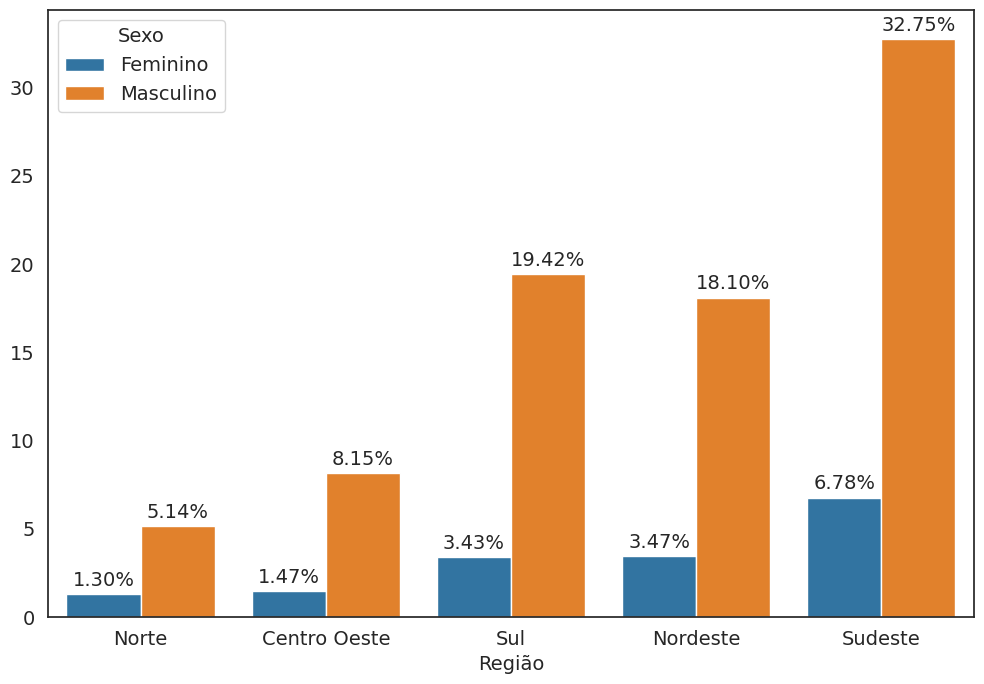

In [40]:
visualizacao.barplot_view_procents(
    qtd_region_gender.sort_values(["counts"], ascending=True),
    x="regiao",
    y="Porcentagem regiao",
    hue="sexo",
    xlabel="Região",
    title_legend="Sexo",
    figsize=(10, 7),
    save_path="../imagens/qtd_região.png",
)

## Adicionar os eixos e somar de cada candidato

In [41]:
dataset_poscomp["matematica"] = dataset_poscomp.loc[
    :,
    [
        "matemática discreta",
        "cálculo diferencial e integral",
        "álgebra linear",
        "geometria analítica",
        "análise combinatória",
        "probabilidade e estatística",
        "lógica matemática",
    ],
].sum(axis=1)

In [42]:
dataset_poscomp["fund_computacao"] = dataset_poscomp.loc[
    :,
    [
        "organização de arquivos e dados",
        "técnicas de programação",
        "circuitos digitais",
        "análise de algoritmos",
        "teoria dos grafos",
        "linguagens formais, autômatos e computabilidade",
        "algoritmos e estruturas de dados",
        "linguagens de programação",
        "sistemas operacionais",
        "arquitetura e organização de computadores",
    ],
].sum(axis=1)

In [43]:
dataset_poscomp["tec_computacao"] = dataset_poscomp.loc[
    :,
    [
        "redes de computadores",
        "computação gráfica",
        "inteligência artificial",
        "engenharia de software",
        "sistemas distribuídos",
        "compiladores",
        "processamento de imagens",
        "banco de dados",
    ],
].sum(axis=1)

In [44]:
dataset_poscomp["total"] = (
    dataset_poscomp["matematica"]
    + dataset_poscomp["fund_computacao"]
    + dataset_poscomp["tec_computacao"]
)

In [45]:
# será selecionados candidatos uma unica vez, ou seja não terá dados duplicados pelos candidatos.
dataset_unique_regis = dataset_poscomp.drop_duplicates(
    subset="cpf", keep="first", ignore_index=True
)

In [46]:
df_unique_regis = dataset_unique_regis[
    (dataset_unique_regis["cargo"] != "Autoavaliação")
]

In [47]:
unique_regis = dataset_unique_regis[
    (dataset_unique_regis["presente dia1"] != "N")
    & (dataset_unique_regis["cargo"] != "Autoavaliação")
]

In [48]:
sexo = df_unique_regis.groupby("presente dia1").size().reset_index()

In [49]:
sexo.loc["Total"] = sexo.sum()
sexo = sexo.T
sexo.rename(columns={1: "presentes"}, inplace=True)
sexo.drop("presente dia1", axis=0)

# Converter as colunas 'Total' e 'presentes' para o tipo numérico
colunas_numericas = ["Total", "presentes"]
sexo[colunas_numericas] = sexo[colunas_numericas].apply(pd.to_numeric, errors="coerce")
sexo["taxa_desistencia"] = ((sexo["Total"] - sexo["presentes"]) / sexo["Total"]) * 100
sexo.dropna(inplace=True)
sexo

,0,presentes,Total,taxa_desistencia
0,2060,9250.0,11310.0,18.21397


In [50]:
np.round(sexo["taxa_desistencia"], decimals=2)

0    18.21
Name: taxa_desistencia, dtype: float64

In [51]:
df_unique_regis["cargo"].value_counts()

cargo
Mestrado/Doutorado    11310
Name: count, dtype: int64

In [52]:
teste_dados = unique_regis.loc[
    :,
    [
        "estado",
        "sexo",
        "regiao",
        "matematica",
        "fund_computacao",
        "tec_computacao",
        "total",
    ],
]

In [53]:
teste_dados = teste_dados[teste_dados["total"] >= 6]

In [54]:
def calcular_percentagem_acertos(dados, coluna_acertos):
    dados["%acerto_" + coluna_acertos] = (
        dados[coluna_acertos] / dados[coluna_acertos].sum()
    ) * 100


# Exemplo de uso:
# Supondo que 'teste_dados' é o seu DataFrame
calcular_percentagem_acertos(teste_dados, "matematica")
calcular_percentagem_acertos(teste_dados, "fund_computacao")
calcular_percentagem_acertos(teste_dados, "tec_computacao")
calcular_percentagem_acertos(teste_dados, "total")

In [55]:
# Bases de dados filtradas com a porcentagens de acertos por eixos de cada estado
percentil_eixos = (
    teste_dados.groupby("estado")
    .agg(
        {
            "%acerto_matematica": "sum",
            "%acerto_fund_computacao": "sum",
            "%acerto_tec_computacao": "sum",
            "%acerto_total": "sum",
        }
    )
    .reset_index()
)

In [56]:
# Bases de dados filtradas com a porcentagens de acertos por eixos de cada sexo
percentil_sexo = (
    teste_dados.groupby("sexo")
    .agg(
        {
            "%acerto_matematica": "sum",
            "%acerto_fund_computacao": "sum",
            "%acerto_tec_computacao": "sum",
            "%acerto_total": "sum",
        }
    )
    .reset_index()
)

In [57]:
# Bases de dados filtradas com a porcentagens de acertos por eixos de cada região
percentil_regiao = (
    teste_dados.groupby("regiao")
    .agg(
        {
            "%acerto_matematica": "sum",
            "%acerto_fund_computacao": "sum",
            "%acerto_tec_computacao": "sum",
            "%acerto_total": "sum",
        }
    )
    .reset_index()
)

In [58]:
percentil_eixos.columns

Index(['estado', '%acerto_matematica', '%acerto_fund_computacao',
       '%acerto_tec_computacao', '%acerto_total'],
      dtype='object')

In [59]:
percentil_eixos = percentil_eixos.round(
    {"%acerto_matematica": 2, "%acerto_fund_computacao": 2, "%acerto_tec_computacao": 2}
)

In [60]:
percentil_eixos

,estado,%acerto_matematica,%acerto_fund_computacao,%acerto_tec_computacao,%acerto_total
0,AC,0.05,0.04,0.04,0.043200
1,AL,1.54,1.49,1.54,1.514895
2,AM,0.61,0.66,0.65,0.646206
3,AP,0.07,0.08,0.11,0.087841
4,BA,1.09,1.22,1.18,1.173252
5,CE,5.75,5.61,5.77,5.686257
6,DF,0.81,0.77,0.78,0.785528
7,ES,3.64,3.43,3.36,3.466475
8,GO,3.64,3.89,3.88,3.821078
9,MA,2.52,2.62,2.81,2.640986


## Tratamento da especilidade dos candidatos

In [61]:
data_poscomp_esp = dataset_unique_regis.query("especialidade.notnull()")

In [62]:
data_poscomp_esp = data_poscomp_esp[data_poscomp_esp["presente dia1"] != "N"]

In [63]:
data_poscomp_esp.shape

(9250, 40)

In [64]:
# Converter todos os elementos para minúsculas
data_poscomp_esp["especialidade"] = data_poscomp_esp["especialidade"].str.lower()

In [65]:
import re


# definir uma expressão regular para encontrar os caracteres '?'
def substituir_caracteres(df, caractere):
    regex = r"\b{}\b".format(re.escape(caractere))

    # substituir os caracteres '?' por um caractere vazio em todas as linhas da coluna 'Texto'
    df["especialidade"] = df["especialidade"].apply(lambda x: re.sub(regex, "", x))

    return df

In [66]:
def remover_e(frase):
    if frase.endswith(" e"):
        frase = frase.rstrip(" e")
    # if frase.endswith(" a"):
    #     frase = frase.rstrip(" a")
    return frase


# # Aplicar a função em uma coluna do DataFrame
# dados_disciplinas['ESPECIALIDADE'] = dados_disciplinas['ESPECIALIDADE'].apply(remover_e)

In [67]:
def substituir_palavras(df, palavras_a_substituir, palavra_substituta):
    # Para cada palavra a ser substituída
    for palavra in palavras_a_substituir:
        # Use uma expressão regular para encontrar a palavra inteira e aplicar a substituição
        padrao = r"\b" + re.escape(palavra) + r"\b"
        df["especialidade"] = df["especialidade"].str.replace(
            padrao, palavra_substituta, regex=True
        )

    # Retorna o novo DataFrame com as palavras substituídas
    return df

In [68]:
data_poscomp_esp = substituir_caracteres(data_poscomp_esp, "?")
data_poscomp_esp = substituir_caracteres(data_poscomp_esp, "\\")
data_poscomp_esp = substituir_caracteres(data_poscomp_esp, " \ ")
data_poscomp_esp = substituir_caracteres(data_poscomp_esp, "\ ")

# Remover caracteres "\\"
data_poscomp_esp["especialidade"] = data_poscomp_esp["especialidade"].str.replace(
    r"\\", ""
)
data_poscomp_esp["especialidade"] = data_poscomp_esp["especialidade"].str.replace(
    r" à", ""
)
data_poscomp_esp["especialidade"] = data_poscomp_esp["especialidade"].str.replace(
    r".", ""
)
data_poscomp_esp["especialidade"] = data_poscomp_esp["especialidade"].str.replace(
    r":", ""
)
data_poscomp_esp["especialidade"] = data_poscomp_esp["especialidade"].str.replace(
    r",", ""
)
data_poscomp_esp["especialidade"] = data_poscomp_esp["especialidade"].str.replace(
    "\xa0", ""
)

In [69]:
# # buscando as três primeiras palavras de cada texto sem as vírgulas
# primeiras_palavras = data_poscomp['ESPECIALIDADE'].str.split().apply(lambda x: x[:3])

# # adicionando as palavras como uma nova coluna no dataframe
# data_poscomp['ESPECIALIDADE'] = primeiras_palavras

# # removendo as vírgulas da coluna 'Primeiras Palavras'
# data_poscomp['ESPECIALIDADE'] = data_poscomp['ESPECIALIDADE'].apply(lambda x: ' '.join(word.replace(',', '') for word in x))

# # imprimindo o dataframe resultante

In [70]:
# data_poscomp['ESPECIALIDADE'] = data_poscomp['ESPECIALIDADE'].apply(remover_e)

#### Junção das especialidades

In [71]:
data_poscomp_esp = substituir_palavras(
    data_poscomp_esp,
    [
        "inteligência computacional e processamento gráfico",
        "inteligência computacional",
        "inteligência artificial e banco de dados",
        "otimização e inteligência artificial",
        "lógica inteligência artificial e métodos formais",
        "inteligência aplicada",
        "inteligencia computacional",
        "inteligencia artificial",
        "inteligência e modelagem computacional",
        "matemática e inteligência artificial",
        "outrasinteligência artificial",
        "redes neurais e computação gráfica",
        "sistemas nebulosos e redes neurais artificiais",
        "redes neuronais artificiais",
    ],
    "inteligência artificial",
)

In [72]:
data_poscomp_esp = substituir_palavras(
    data_poscomp_esp,
    [
        "engenharia de software",
        "engenharia de software técnicas de reúso testes e qualidade",
        "engenharia de software banco de dados e informática e educação",
        "engenharia de software e banco de dados",
        "engenharia de software e redes de computadores",
        "engenharia de software e sistemas de informação",
        "engenharia de software e linguagens de programação",
        "engenharia de software e usabilidade",
        "engenharia de software banco de dados e interação humano computador",
        "engenharia de software e sistemas de informação/sistemas web e multimídia interativos",
        "engenharia de software e sistemas de computação",
        "engenharia de software experimental",
        "engenharia de software gerenciamento de informações e interfaces homem-computador",
        "engenharia de software e linguagens de programacao",
        "engenharia de software e sistemas computacionais",
        "engenharia de software e sistemas de informação / sistemas web e multimídia interativos",
        "engenharia de software baseada em buscas",
        "engenharia de software e linguagens de programacão",
        "engenharia de software/sistemas web e multimídia interativos",
        "engenharia de software / sistemas web e multimídia interativos",
        "otimização em engenharia de software",
        "agentes de software e ontologias aplicadas engenharia de software",
        "qualidade de software",
        "engenharia  de software",
        "verificação e teste de software",
        "avaliação e melhoria de processos de software",
        "processo de desenvolvimento de software visando a usabilidade",
        "processos de desenvolvimento de software",
        "controle da engenharia de software",
        "ambientes de desenvolvimento de software",
        "métricas de software e gerência de projetos",
        "gerência de projetos de desenvolvimento de software",
        "melhoria de processo de software",
        "projetos integrados de software e hardware",
        "teste de software",
        "desenvolvimento dirigido a modelos mdd - model-driven development",
        "desenvolvimento de ferramentas de gerência e administracão",
        "métodos ágeis",
    ],
    "engenharia de software",
)

In [73]:
data_poscomp_esp = substituir_palavras(
    data_poscomp_esp,
    [
        "sistemas de computação",
        "sistemas de computaçãoredes de computadores",
        "sistemas de computaçãomicroeletrônica e processamento de sinais",
        "sistemas de computaçãoredes e sistemas distribuídos",
        "sistemas de computaçãosistemas inteligentes",
        "sistemas de computaçãoarquitetura de sistemas de computação  e sistemas operacionais",
        "sistemas de computaçãovisualização e interação",
        "sistemas de computaçãoarquitetura de sistemas de computação e sistemas operacionais",
        "sistemas de computaçãocomputação aplicada",
        "sistemas computacionais complexos",
        "sistema de computação",
        "análise e modelagem de desempenho em sistemas de computação",
        "escalabilidade e eficiência em sistemas de computação",
        "tecnologias e sistemas de computação",
        "analise de desempenho de sistemas de computação",
        "sistemas computacionais para bioinformática",
        "sistemas complexos de partículas e teoria de controle",
        "sistemas computacionais",
        "sistemas computacionais embarcados",
        "sistemas complexos adaptativos",
        "engenharia de sistemas de computação",
        "engenharia desistemascomputacionais",
        "engenharia de sistema e computação",
        "engenharia de sistemas",
        "sistemas de computação e informação",
        "sistemas de computação embarcados",
        "segurança em sistemas de computação",
        "sistemas de computação web",
        "projeto de sistemas de computação",
        "controle de sistemas de computação",
        "sistemas e tecnologias da computação",
        "ciência computacional",
        "ciência da computação",
        "ciências de computação",
    ],
    "sistemas de computação",
)

In [74]:
data_poscomp_esp = substituir_palavras(
    data_poscomp_esp,
    [
        "sistemas de informação",
        "sistemas de informação e computação",
        "sistemas de informação para a web",
        "sistemas de informação e banco de dados",
        "sistemas de informação e processamento gráfico",
        "sistemas de informações multimídia",
        "sistemas de informação geográfica e geoprocessamento",
        "sistema de informação",
        "modelagem e gerência de sistemas de informação",
        "gerência de desenvolvimento de sistemas de informação",
        "desenvolvimento de sistemas de informação",
        "alinhamento estratégico de tecnologias e sistemas de informação",
        "gestão estratégica de ti",
        "gestão de riscos",
        "gestão do conhecimento",
        "gestão de sistemas complexos",
        "sistemas de gestão empresarial",
        "gestão da informação",
        "gestão de processos de negócios",
    ],
    "sistemas de informação",
)

In [75]:
data_poscomp_esp = substituir_palavras(
    data_poscomp_esp,
    [
        "computação aplicada",
        "computação aplicada a biociências",
        "computação aplicadasistemas de computação",
        "computação aplicadasistemas de informação",
        "computação aplicadainteligência computacional",
        "computação científica e aplicada",
    ],
    "computação aplicada",
)

In [76]:
data_poscomp_esp = substituir_palavras(
    data_poscomp_esp,
    [
        "redes de computadores",
        "redes de computadores e sistemas distribuídos",
        "redes de computadores e telecomunicações",
        "redes de computadores e comunicação de dados",
        "redes de computadores e sistemas distribuidos",
        "redes de computadores  e sistemas embarcados",
        "redes de comunicação e sistemas distribuídos",
        "redes de computadores e de telecomunicações",
        "redes de computadores e sistemas embarcados",
        "redes de comunicação",
        "redes de comunicações",
        "gerenciamento de redes de computadores",
        "redes e sistemas distribuídos",
        "redes de sensores sem fio",
        "gerência de redes",
        "gerenciamento de redes",
        "segurança em redes",
        "engenharia de tráfego em redes ópticas",
        "segurança de redes",
        "redes e sistemas distribuídos",
        "projeto de redes e segurança de dados",
        "sistemas distribuídos e redes de computadores",
        "sistemas distribuídos e  visão computacional",
        "sistemas distribuídos e programação concorrente",
        "sistemas distribuídos e programação concorrente/sistemas embarcados",
        "sistemas distribuídos e computação de alto desempenho",
        "sistemas distribuídos e programação concorrente / sistemas embarcados",
        "sistemas distribuídos/sistemas embarcados",
        "sistemas distribuídos / sistemas embarcados",
        "computação distribuida",
        "computação distribuída",
        "desenvolvimento de software distribuído",
        "técnicas de modelagem de sistemas distribuídos",
        "segurança e sistemas distribuídos",
        "middleware e objetos distribuídos",
        "algoritmos distribuídos",
        "distribuição e redes",
        "aplicações distribuídas",
        "sistemas distribuídos",
        "redes de computadores/sistemas embarcados",
        "redes e sistemas distribuidos",
        "redes móveis",
        "redes de computadores / sistemas embarcados",
        "redes de computadores evoluídos e robóticos",
        "projeto e teste de circuitos digitais",
        "projeto de sistemas e circuitos",
        "internet e web das coisas",
        "desenvolvimento de plataformas para iot (internet das coisas)",
        "serviços internet escaláveis e eficientes",
        "computação em nuvem",
        "cloud computing",
        "sistemas web e multimídia interativos",
        "hipertexto e multimídia",
        "multimídia e processamento digital de sinais",
        "hipermídia e multimídia",
        "computação ubíqua e pervasiva",
        "computação móvel e ubíqua",
    ],
    "redes de computadores",
)

In [77]:
data_poscomp_esp = data_poscomp_esp.replace(
    to_replace={
        "redes": "redes de computadores",
        "desenvolvimento de plataformas para iot (internet das coisas)": "redes de computadores",
    },
    inplace=False,
)

In [78]:
data_poscomp_esp = substituir_palavras(
    data_poscomp_esp,
    [
        "sistemas embarcados e engenharia de software",
        "sistemas embarcados",
        "sistemas embarcados evoluídos e robóticos",
        "sistemas embarcados e sistemas digitais",
        "sistemas embarcados e robótica",
        "sistemas digitais e embarcados",
        "velha-sistemas embarcados",
    ],
    "sistemas embarcados",
)

In [79]:
data_poscomp_esp = substituir_palavras(
    data_poscomp_esp,
    [
        "sistemas inteligentes",
        "sistemas inteligentes e lógica",
        "sistemas integrados e distribuidos",
        "sistemas interativos e de informação",
        "sistemas integrados e distribuídos",
        "sistemas integrados de hardware e software",
        "computação inteligente",
        "teste e confiabilidade de sistemas inteligentes",
        "computação inteligente aplicada a mercados financeiros",
        "computação pervasiva sistemas inteligentes",
        "agentes inteligentes e representacao do conhecimento",
        "aprendizado de máquina e sistemas inteligentes",
        "sistemas inteligentes aplicada a mercados financeiros",
    ],
    "sistemas inteligentes",
)

In [80]:
data_poscomp_esp = substituir_palavras(
    data_poscomp_esp,
    [
        "banco de dados",
        "banco de dados e engenharia de software",
        "banco de dados na web e distribuídos",
        "banco de dados e recuperação de informação",
        "banco de dados e imagens",
        "banco de dados/computação gráfica imagens e visualização",
        "banco de dados e web",
        "banco de dados / computação gráfica imagens e visualização",
        "bancos de dados",
        "bancos de dados e imagens",
        "banco de dados e imagens",
        "web e banco de dados",
        "novos algoritmos e arquiteturas para banco de dados espaciais distribuídos",
        "projeto de banco de dados",
        "modelagem conceitual e banco de dados",
        "gerenciamento de dados e informações",
        "gerência de dados distribuidos web clusters e grids",
        "gerência de dados da web",
        "gerência de dados e aplicações",
        "métodos baseados em dados",
        "inferência em dados complexos",
        "gerenciamento de dados semi-estruturados",
    ],
    "banco de dados",
)

In [81]:
data_poscomp_esp = substituir_palavras(
    data_poscomp_esp,
    [
        "computação visual e inteligente",
        "computação visual",
        "computação visual e sistemas inteligentes",
        "computação visual e inteligência artificial",
    ],
    "computação visual",
)

In [82]:
data_poscomp_esp = substituir_palavras(
    data_poscomp_esp,
    [
        "aprendizado de máquina e mineração de dados",
        "aprendizado de máquina",
        "aprendizado de máquina e processamento de línguas naturais",
        "aprendizado de maquina e interação",
        "aprendizagem de máquina",
        "aprendizagem de máquina e mineração",
        "aprendizagem de maquina e mineracao",
        "aprendizagem de máquina e sistemas inteligentes",
        "aprendizagem de máquina e mineracão",
        "descoberta do conhecimento e aprendizado de máquina",
        "mineração de dados",
        "mineração análise e visualização de dados",
        "mineração de dados e descoberta de conhecimento",
        "mineiração de dados",
        "aprendizado de máquina e mineração",
        "aprendizagem e otimização",
        "aprendizado automático de modelos",
        "aprendizado de máquina e descoberta de conhecimento",
        "aprendizado de máquina e mineracão",
        "reconhecimento de padrões",
        "reconhecimento de padrões e processamento de sinais",
        "reconhecimento de padroes e processamento de sinais",
        "aprendizado de máquina e processamento de sinais",
        "visualização de informações",
        "visualização da informação",
        "aprendizado de máquina e sistemas inteligentes",
    ],
    "aprendizado de máquina",
)

In [83]:
data_poscomp_esp = substituir_palavras(data_poscomp_esp, [], "ciência computacional")

In [84]:
data_poscomp_esp = substituir_palavras(
    data_poscomp_esp,
    [
        "ciência de dados",
        "ciência de dados e engenharia de software",
        "ciência dos dados",
        "data science",
        "análise de padrões em dados",
        "análise de padrões",
        "análise de redes sociais",
        "análise de dados descoberta de conhecimento e recuperação de informação",
        "análise de dados",
    ],
    "ciência de dados",
)

In [85]:
data_poscomp_esp = substituir_palavras(
    data_poscomp_esp,
    [
        "arquitetura de computadores e compiladores",
        "arquitetura de sistemas computacionais",
        "arquitetura e projeto de sistemas computacionais",
        "arquitetura de computadores e sistemas distribuídos",
        "arquitetura de computadores e sistemas digitais",
        "arquiteturas e algoritmos para máquinas paralelas e distribuídas",
        "arquitetura de computadores compiladores e design de hardware",
        "arquiteturas e redes de computadores",
        "arquitetura de sistemas de computação",
        "arquitetura e sistemas de computação",
        "arquitetura de computadores e redes de computadores",
        "arquitetura de computadores e sistemas distribuidos",
    ],
    "arquitetura de computadores",
)

In [86]:
data_poscomp_esp = substituir_palavras(
    data_poscomp_esp,
    [
        "otimização e inteligência artificial",
        "otimização",
        "otimização e raciocínio automático",
        "otimização e automação de sistemas",
        "otimização combinatória",
        "mecânica dos fluidos computacional",
        "mecânica dos fluidos computacional/otimização/modelos estocásticos",
        "mecânica dos fluidos computacional / otimização / modelos estocásticos",
        "otimização/otimização/modelos estocásticos",
        "otimização / otimização / modelos estocásticos",
        "algoritmos e grafos",
        "algoritmos otimização e teoria da computação",
        "algoritmos e otimização",
        "algoritmos grafos e combinatória",
        "algoritmos otimização e complexidade computacional",
        "métodos computacionais de otimização (interdepartamental)",
        "métodos numéricos e otimização",
        "heurísticas e meta-heurísticas otimização (programação linear não linear e inteira)",
        "sistemas de otimização",
        "métodos computacionais de otimização",
        "computacao evolucionaria aprendizagem e otimizacao",
        "técnicas heurísticas e metaheurísticas para otimização",
        "algoritimos otimização e teoria da computação",
        "computacão evolucionária aprendizagem e otimizacão",
        "otimização (interdepartamental)",
        "heurísticas e meta-heurísticas otimização (programação linear não linear e inteira)",
        "combinatória e teoria da computação",
        "algoritmos e combinatória",
        "grafos e combinatória",
        "outrasalgoritmos e combinatória",
        "matemática discreta e combinatória",
    ],
    "otimização",
)

In [87]:
data_poscomp_esp = substituir_palavras(
    data_poscomp_esp,
    [
        "teoria da computação",
        "teoria e algoritmos em grafos",
        "teoria lógica e métodos formais",
        "teoria aplicada computação",
        "teoria dos grafos e combinatória",
        "teoria dos grafos",
        "teoria da computaçãoanálise de algoritmos e complexidade de computação_x000d_otimização",
        "linguagens formais e autômatos",
        "algoritmos e complexidade computacional",
    ],
    "teoria da computação",
)

In [88]:
data_poscomp_esp = substituir_palavras(
    data_poscomp_esp,
    [
        "metodologia e técnicas da computação",
        "metodologia e técnicas de computação",
        "metodologia da computação",
        "metodologias e técnicas de computação",
        "metodologia e técnicas de programação",
        "metodologia e tecnicas de computação",
        "metodologia e técnicas da computaçãoengenharia de software",
        "metodologia e técnicas da computaçãolinguagens de programação",
        "metodologia e técnicas da computaçãobanco de dadosengenharia de dados e conhecimento",
        "metodologia e técnicas da computaçãocomputação gráfica processamento de imagens e visão computacional",
        "metodologia e técnicas da computaçãobanco de dados",
        "metodologia e técnicas da computaçãoengenharia de softwarefábrica de software",
        "fundamentos e métodos de computação",
        "fundamentos da computação",
        "fundamentos de computação",
        "fundamentos matemáticos da computação",
        "fundamentos matemáticos da computacão",
    ],
    "metodologias e técnicas de computação",
)

In [89]:
data_poscomp_esp = substituir_palavras(
    data_poscomp_esp,
    [
        "computação gráfica imagens e visualização",
        "computação gráfica",
        "computação gráfica processamento de imagens e interação",
        "computação gráfica processamento de imagens realidade virtual e interação humano computador",
        "computação gráfica e processamento de imagens",
    ],
    "computação gráfica",
)

In [90]:
data_poscomp_esp = substituir_palavras(
    data_poscomp_esp,
    [
        "tecnologias aplicadas educação e saúde",
        "informática na educação",
        "informática educação e sociedade",
        "educação em engenharia de software",
        "informática e educação",
        "inovações tecnológicas para apoiar a educação",
        "tecnologias educacionais e assistivas",
        "elaboração de software educativo e objetos de aprendizagem",
        "tecnologias educacionais",
        "métodos e recursos para o ensino de ciências e tecnologia",
    ],
    "informática na educação",
)

In [91]:
data_poscomp_esp = substituir_palavras(
    data_poscomp_esp,
    [
        "bioinformática",
        "bioinformática estrutural",
        "biometria",
        "bioinformática e computação bioinspirada",
        "bioinformática e biologia computacional",
        "biologia matemática e computacional",
        "biologia computacional",
    ],
    "bioinformática",
)

In [92]:
data_poscomp_esp = substituir_palavras(
    data_poscomp_esp,
    [
        "robótica móvel",
        "robótica",
        "robótica cooperativa",
        "robótica e automação inteligentes",
        "robótica coletiva",
        "robótica visão computacional e processamento gráfico",
        "automação e robótica",
    ],
    "robótica",
)

In [93]:
data_poscomp_esp = substituir_palavras(
    data_poscomp_esp,
    [
        "modelagem computacional",
        "modelagem computacional do sistema solo-planta-animal",
        "modelagem e simulação de sistemas",
        "modelagem de negócios",
        "modelagem matemático computacional e simulação",
        "modelagem e métodos computacionais",
        "modelagem e simulação",
        "modelagem conceitual",
        "modelagem e arquitetura",
        "modelagem de dados",
        "modelos e arquiteturas para sistemas inteligentes",
        "modelos computacionais e cognitivos",
    ],
    "modelagem computacional",
)

In [94]:
data_poscomp_esp = substituir_palavras(
    data_poscomp_esp,
    [
        "linguagens de programação e banco de dados",
        "linguagens de programação",
        "linguagem de programação e métodos formais",
        "linguagens e ambientes de programação",
        "linguagens de programação e sistemas de tipos",
        "linguagens de programação e métodos formais",
        "algoritimos experimentais",
        "algoritmos experimentais",
    ],
    "linguagens de programação",
)

In [95]:
data_poscomp_esp = substituir_palavras(
    data_poscomp_esp,
    [
        "visão computacional",
        "visão computacional reconhecimento de padrões e computação forense",
        "visão e robótica",
        "visão computacional e robótica",
        "visão computacional realidade virtual e aumentada",
        "processamento de imagens",
        "processamento de imagens e visão computacional",
        "processamento de imagens e sinais algoritmos e arquiteturas",
        "processamento de imagens e sinais",
        "processamento gráfico",
        "processamento gráfico interação e computação aplicada",
        "processamento gráfico e inteligência artificial",
        "processamento gráfico aplicado",
        "processamento grafico",
        "visão computacional aprendizado de máquina e computação forense",
        "visão computacional interação e computação aplicada",
        "visão computacional e visão computacional",
        "visão computacional e inteligência artificial",
        "visão computacional e sinais algoritmos e arquiteturas",
        "visão computacional aplicado",
        "visão computacional e sinais",
        "visao computacional realidade virtual e aumentada",
        "visão computacional linguagens de programação e arquiteturas",
    ],
    "visão computacional",
)

In [96]:
data_poscomp_esp = substituir_palavras(
    data_poscomp_esp,
    [
        "tecnologias computacionais para agricultura e pecuária",
        "agropecuária de precisão",
        "desenvolvimento e aplicação de tecnologias computacionais em sistemas agrícolas e de pecuária",
        "aplicações da computação",
    ],
    "aplicações computacionais",
)

In [97]:
data_poscomp_esp = substituir_palavras(
    data_poscomp_esp,
    [
        "computação paralela e distribuída",
        "sistemas paralelos e distribuídos",
        "algoritmos paralelos e distribuídos",
    ],
    "processamento paralelo e distribuído",
)

In [98]:
data_poscomp_esp = substituir_palavras(
    data_poscomp_esp,
    [
        "tecnologia da informação para grandes coorporações",
        "gestão da tecnologia da informação",
    ],
    "tecnologia da informação",
)

In [99]:
data_poscomp_esp = substituir_palavras(
    data_poscomp_esp,
    [
        "interfaces humano-computador",
        "interação humano-computador",
        "realidade virtual e interação humano computador",
        "interface humano-computador",
        "design de artefatos digitais",
    ],
    "interação humano-computador",
)

In [100]:
f = data_poscomp_esp[data_poscomp_esp["especialidade"].str.contains("aplica")]
print(f["especialidade"].sort_values().value_counts())

especialidade
computação aplicada                  393
aplicações computacionais             95
segurança e criptografia aplicada     21
Name: count, dtype: int64


In [101]:
especialidades = data_poscomp_esp["especialidade"].value_counts()
especialidades = pd.DataFrame(especialidades)
especialidades.head(60)

,count
especialidade,
inteligência artificial,1538
engenharia de software,1349
sistemas de computação,1150
redes de computadores,678
sistemas de informação,523
computação aplicada,393
banco de dados,387
aprendizado de máquina,267
otimização,255


In [102]:
df = data_poscomp_esp.copy()

contagem_valores = df["especialidade"].value_counts()

# Identifica valores que ocorrem menos de 100 vezes
valores_a_renomear = contagem_valores[contagem_valores <= 109].index

# Define o novo valor (categoria) para as áreas com contagem menor que 100
novo_valor = "Demais áreas"

# Renomeia as áreas com contagem menor que 100 para 'Outras Áreas'
df.loc[df["especialidade"].isin(valores_a_renomear), "especialidade"] = novo_valor

# Agora, as áreas com contagem menor que 100 foram renomeadas para 'Outras Áreas'
df.especialidade.value_counts()

especialidade
inteligência artificial                  1538
engenharia de software                   1349
sistemas de computação                   1150
Demais áreas                              814
redes de computadores                     678
sistemas de informação                    523
computação aplicada                       393
banco de dados                            387
aprendizado de máquina                    267
otimização                                255
metodologias e técnicas de computação     224
visão computacional                       193
sistemas inteligentes                     188
sistemas embarcados                       177
modelagem computacional                   164
arquitetura de computadores               163
ciência de dados                          158
computação visual                         156
informática na educação                   121
processamento paralelo e distribuído      118
computação gráfica                        117
tecnologia da inform

In [103]:
linhas_inteligenciaArtificial = [
    "inteligência artificial",
    "otimização",
    "aprendizado de máquina",
    "visão computacional",
    "sistemas inteligentes",
    "computação visual",
    "ciência de dados",
]

linhas_redesComputadores = [
    "redes de computadores",
    "sistemas embarcados",
    "processamento paralelo e distribuído",
]

linhas_engenhariaSoftware = [
    "engenharia de software",
    "metodologias e técnicas de computação",
    "modelagem computacional",
]

linhas_sistemaComputacao = [
    "sistemas de computação",
    "sistemas de informação",
    "arquitetura de computadores",
    "tecnologia da informação",
]

linhas_outros = [
    "banco de dados",
    "computação aplicada",
    "informática na educação",
    "computação gráfica",
    "aplicações computacionais",
    "Demais áreas",
]

In [104]:
# Defina as condições e os valores correspondentes para a nova coluna
condicoes = [
    df["especialidade"].isin(linhas_inteligenciaArtificial),
    df["especialidade"].isin(linhas_sistemaComputacao),
    df["especialidade"].isin(linhas_engenhariaSoftware),
    df["especialidade"].isin(linhas_redesComputadores),
    df["especialidade"].isin(linhas_outros),
]

valores = [
    "inteligência artificial",
    "sistemas de computação",
    "engenharia de software",
    "redes de computadores",
    "Outros",
]  # Valores correspondentes às condições

# Use a função numpy.select para criar a nova coluna
df["linhas_pesquisas"] = np.select(condicoes, valores, default="Demais areas")

# Exiba o DataFrame resultante
df["linhas_pesquisas"].value_counts()

linhas_pesquisas
inteligência artificial    2755
sistemas de computação     1953
Outros                     1832
engenharia de software     1737
redes de computadores       973
Name: count, dtype: int64

In [105]:
from wordcloud import WordCloud 

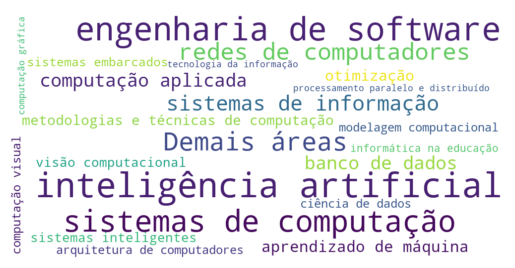

In [106]:
text = df['especialidade'].value_counts()[:80]
text = text.to_dict()

stopwords = set(['o', 'a', 'e', 'é', 'de', 'da', 'do', 'para', ' e'])

wordcloud2 = WordCloud(background_color="white",
                       random_state=42, 
                       min_word_length=3,
                        width=1000, height=500,
                        stopwords=stopwords
                       ).generate_from_frequencies(text)
# WordCloud.generate_from_frequencies

plt.imshow(wordcloud2, interpolation="bilinear")
plt.axis("off")
# plt.margins(x=0, y=0)
plt.savefig('../imagens/nuvem_palavras.pdf', format='pdf', dpi = 300, bbox_inches='tight')
plt.show()

In [107]:
# contagem_areas = data_poscomp.groupby(['ESTADO', 'ESPECIALIDADE']).size().reset_index(name='CONTAGEM')
# contagem_areas = contagem_areas.sort_values(['ESTADO', 'CONTAGEM'], ascending=[True, False])
# areas_mais_frequentes = contagem_areas.groupby('ESTADO').first().reset_index()
# print(areas_mais_frequentes)

In [122]:
df.to_csv('db_poscomp.csv', index=False)

In [109]:
# Supondo que 'data_poscomp_esp' seja o seu DataFrame
qtd = df.groupby(['especialidade', 'estado']).size().reset_index(name='counts')

In [110]:
# Encontre a especialidade predominante para cada estado
idx = qtd.groupby(['estado'])['counts'].transform(max) == qtd['counts']
result_df = qtd[idx]

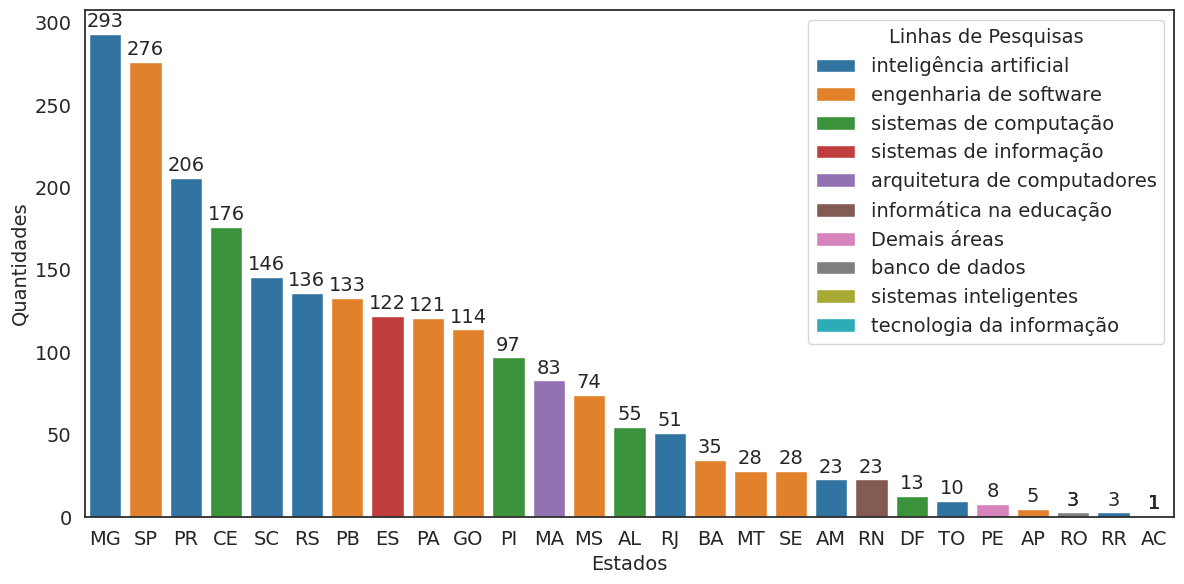

In [111]:
visualizacao.barplot_view(result_df.sort_values(['counts'], ascending=False), 
                          x='estado', y='counts', hue='especialidade', figsize=(12,6), dodge=False,
                         save_path='../imagens/especialidades_estados.pdf', title_legend='Linhas de Pesquisas', ylabel="Quantidades",
                         xlabel="Estados")

In [123]:
# Supondo que 'data_poscomp_esp' seja o seu DataFrame
qtd_sexo = df.groupby(['especialidade', 'sexo']).size().reset_index(name='counts')

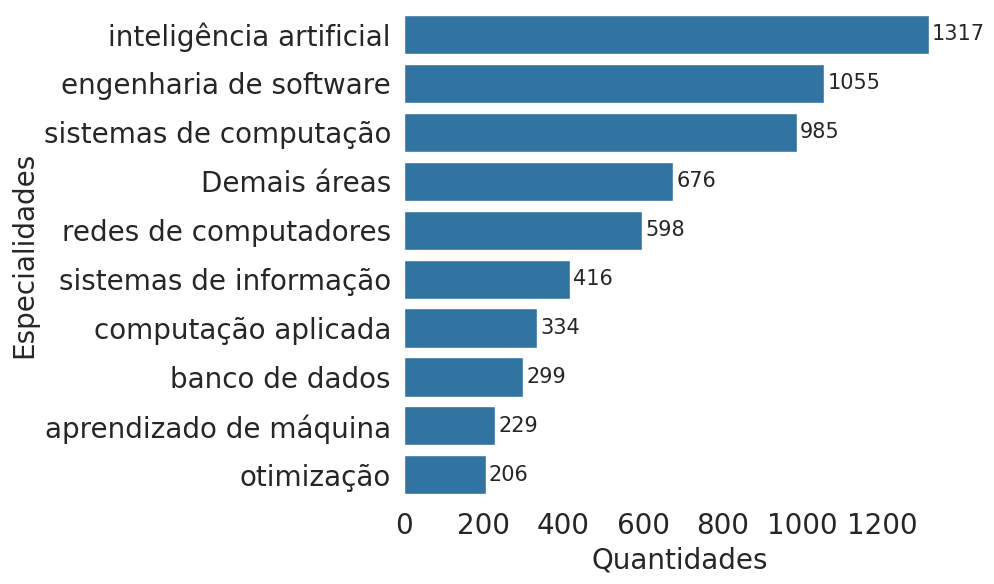

In [205]:
masculino = qtd_sexo[qtd_sexo['sexo'] == 'M']
# Reorder this data frame
masculino = masculino.sort_values(['counts'], ascending=False).reset_index(drop=True)[:10]
visualizacao.barplot_view(masculino.sort_values(['counts'], ascending=False), 
                          y='especialidade', x='counts', figsize=(10,6),
                         save_path='../imagens/especialidades_masculino.pdf', ylabel="Especialidades",
                         xlabel="Quantidades", show_legend=False, fontsize=20)

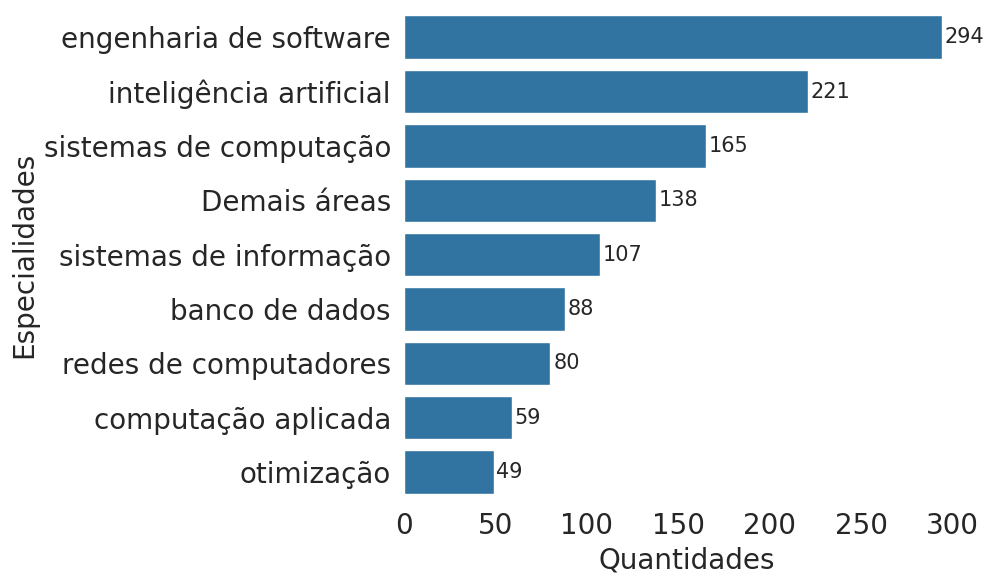

In [206]:
feminino = qtd_sexo[qtd_sexo['sexo'] == 'F']
feminino = feminino.sort_values(['counts'], ascending=False).reset_index(drop=True)[:9]
visualizacao.barplot_view(feminino.sort_values(['counts'], ascending=False), 
                          y='especialidade', x='counts', figsize=(10,6),
                         save_path='../imagens/especialidades_feminina.pdf', ylabel="Especialidades",
                         xlabel="Quantidades", show_legend=False, fontsize=20)

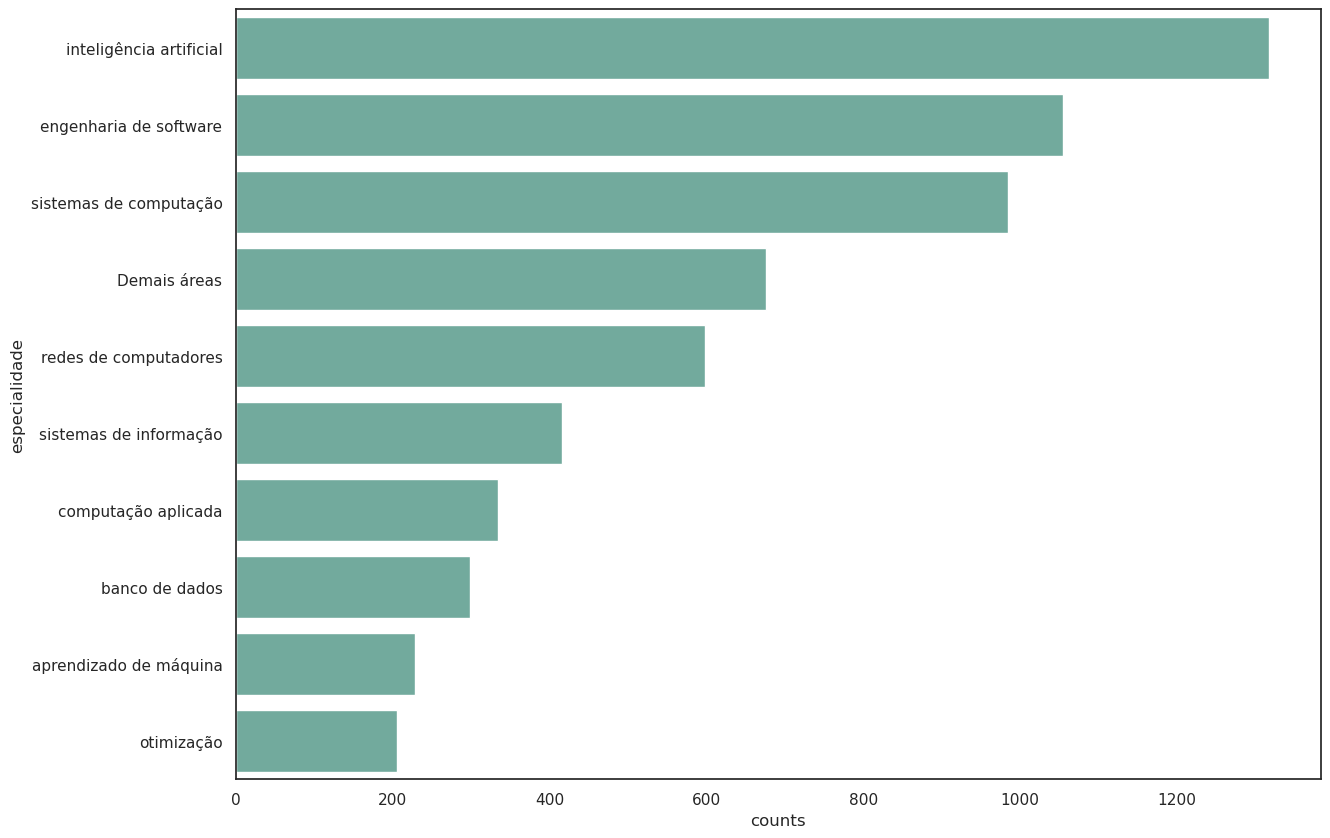

In [144]:
# Set the figure size
plt.figure(figsize=(14, 10))




# Make a barplot
sns.barplot(
    x="counts", 
    y="especialidade", 
    data=masculino, 
    estimator=sum, 
    ci=None, 
    color='#69b3a2'
);


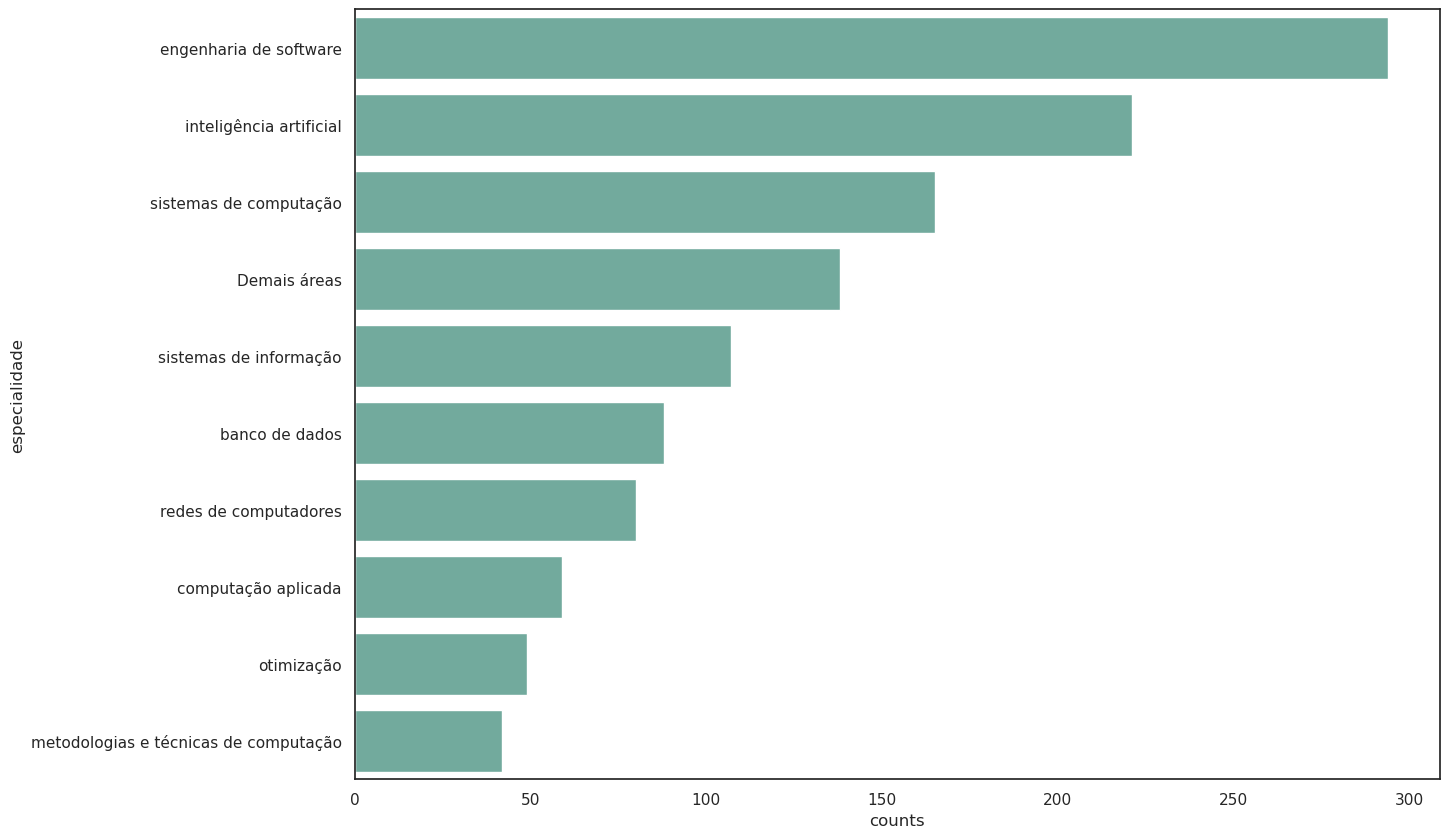

In [145]:
# Set the figure size
plt.figure(figsize=(14, 10))

sns.barplot(
    x="counts", 
    y="especialidade", 
    data=feminino, 
    estimator=sum, 
    ci=None, 
    color='#69b3a2'
);

In [126]:
# Encontre a especialidade predominante para cada estado
idx_sexo = qtd_sexo.groupby(['sexo'])['counts'].transform(max) == qtd_sexo['counts']
result_df_sexo = qtd_sexo[idx_sexo]

In [127]:
result_df_sexo

,especialidade,sexo,counts
16,engenharia de software,F,294
21,inteligência artificial,M,1317


## Pré-processamento dos dados

In [112]:
df_poscomp = df.copy()

In [113]:
df_poscomp.columns

Index(['nome', 'cpf', 'sexo', 'estado', 'inscricao', 'especialidade',
       'presente dia1', 'cargo', 'matemática discreta',
       'cálculo diferencial e integral', 'álgebra linear',
       'geometria analítica', 'análise combinatória',
       'probabilidade e estatística', 'lógica matemática',
       'organização de arquivos e dados', 'técnicas de programação',
       'circuitos digitais', 'análise de algoritmos', 'teoria dos grafos',
       'linguagens formais, autômatos e computabilidade',
       'algoritmos e estruturas de dados', 'linguagens de programação',
       'sistemas operacionais', 'arquitetura e organização de computadores',
       'redes de computadores', 'computação gráfica',
       'inteligência artificial', 'engenharia de software',
       'sistemas distribuídos', 'compiladores', 'processamento de imagens',
       'banco de dados', 'ano', 'idade', 'regiao', 'matematica',
       'fund_computacao', 'tec_computacao', 'total', 'linhas_pesquisas'],
      dtype='object')

In [114]:
100 / len(df_poscomp)

0.010810810810810811

In [115]:
split = StratifiedShuffleSplit(test_size=0.010810810810810811)
for x, y in split.split(df_poscomp, df_poscomp["linhas_pesquisas"]):
    df_x = df_poscomp.iloc[x]
    df_y = df_poscomp.iloc[y]

In [116]:
df_x.shape, df_y.shape

((9150, 41), (100, 41))

In [117]:
df_y["linhas_pesquisas"].value_counts()

linhas_pesquisas
inteligência artificial    30
sistemas de computação     21
Outros                     20
engenharia de software     19
redes de computadores      10
Name: count, dtype: int64

In [118]:
df_x["linhas_pesquisas"].value_counts()

linhas_pesquisas
inteligência artificial    2725
sistemas de computação     1932
Outros                     1812
engenharia de software     1718
redes de computadores       963
Name: count, dtype: int64

In [119]:
def amostragem_estratificada(dataset, percentual):
    split = StratifiedShuffleSplit(test_size=percentual, random_state=1)
    for _, y in split.split(df_poscomp, df_poscomp["linhas_pesquisas"]):
        df_y = df_poscomp.iloc[y]
    return df_y

In [120]:
df_stratified = amostragem_estratificada(df_poscomp, 0.010810810810810811)
df_stratified.shape

(100, 41)

### Aprendizado de Máquina